In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.metrics import roc_auc_score, auc, roc_curve, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
from test_function import *
import random
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from test_function import *
from sklearn.ensemble import GradientBoostingClassifier
import math
import scipy.stats as stats
import statsmodels.api as sm
import pylab as pl

In [2]:
alldata = pd.read_csv('allmodel_denovo.csv', sep = '\t')

In [3]:
original_column = ['SIFT_pred','LRT_pred', 'MA_pred', 'PROVEN_pred', 'SLR_score', 'SIFT_score','LRT_omega', 
                'MA_score', 'PROVEN_score', 'Grantham', 'HMMEntropy','HMMRelEntropy', 'PredRSAB', 'PredRSAI', 
                'PredRSAE','PredBFactorF', 'PredBFactorM', 'PredBFactorS', 'PredStabilityH','PredStabilityM', 
                'PredStabilityL', 'PredSSE', 'PredSSH','PredSSC', 'dscore', 'phyloP_pri', 'phyloP_mam','phyloP_ver',
                   'RNA_seq','UNEECON']

# the features for comparison (to other supervised score)
features = [ 'MetaSVM_score', 'MetaLR_score', 'M-CAP_score', 'REVEL_score','ClinPred_score','CADD_phred_hg19',
            'DANN_score']



x_column  = original_column + ['M-CAP_score', 'REVEL_score']
y_column = 'source'


originaldata = alldata[alldata['source'] == 0] #46787
denovo = alldata[alldata['source'] ==1] #5985

y = originaldata.loc[:,[y_column]].values.flatten()
X = originaldata.loc[:,x_column]

X_denovo = denovo.loc[:,x_column]
y_denovo = denovo.loc[:,[y_column]].values.flatten()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)
Xtrain_denovo, Xtest_denovo, ytrain_denovo, ytest_denovo = train_test_split(X_denovo,y_denovo, test_size = 0.3, random_state = 42)


X_train = pd.concat([X_train, Xtrain_denovo], join= 'inner')
y_train = np.concatenate((y_train, np.full((1,4189),1).flatten())).flatten()

X_test = pd.concat([X_test, Xtest_denovo], join= 'inner')
y_test = np.concatenate((y_test, np.full((1,1796),1).flatten())).flatten()

regression = LogisticRegression(random_state = 42 , solver = 'lbfgs').fit(X_train, y_train)

y_hat = regression.predict_proba(X_test)[:,1]

/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


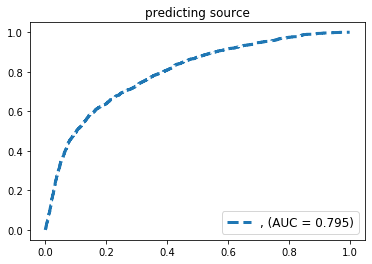

In [48]:
#X_train, X_test, y_train, y_test, y_hat, regression = splitNfit(alldata, x_column, y_column, testsize = 0.3)
drawROC(y_test, y_hat, title = 'predicting source', lastone = True)

In [5]:
y_hat/(1-y_hat)


array([0.26152678, 0.0986425 , 0.0129941 , ..., 0.50541611, 0.48950976,
       0.391338  ])

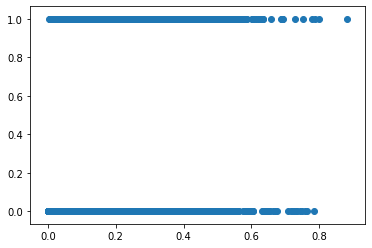

In [12]:
plt.scatter(y_hat, y_test)


In [53]:
coef_overall = regression.coef_.flatten()

coefficient = pd.DataFrame({'regression':coef_overall}, index = x_column)


In [57]:
coefficient['regression'].sort_values()

REVEL_score      -4.431733
M-CAP_score      -2.207410
PROVEN_score     -0.482702
MA_pred          -0.365398
HMMRelEntropy    -0.253990
phyloP_pri       -0.204546
PROVEN_pred      -0.155214
PredBFactorM     -0.080906
PredSSH          -0.075149
PredBFactorS     -0.059391
phyloP_mam       -0.058062
PredBFactorF     -0.045233
Grantham         -0.037211
SLR_score        -0.003701
LRT_omega         0.010723
LRT_pred          0.021732
dscore            0.082605
RNA_seq           0.118366
PredSSC           0.127818
SIFT_score        0.145276
PredRSAB          0.162213
SIFT_pred         0.181498
PredRSAI          0.187517
PredSSE           0.205221
phyloP_ver        0.276931
PredRSAE          0.339623
HMMEntropy        0.407727
MA_score          0.426232
PredStabilityM    0.600210
UNEECON           0.694361
PredStabilityL    1.248539
PredStabilityH    1.301393
Name: regression, dtype: float64

[[11556  2481]
 [  681  1115]]


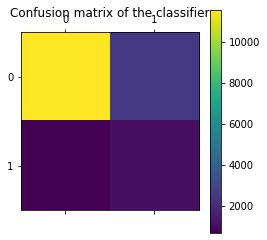

[[12647  1390]
 [  913   883]]


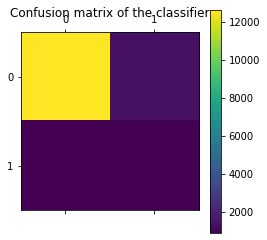

[[12988  1049]
 [ 1012   784]]


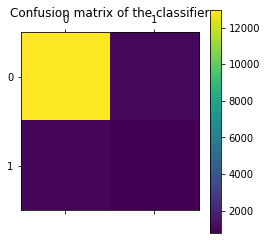

[[13235   802]
 [ 1139   657]]


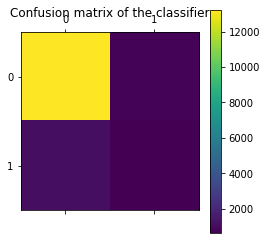

In [49]:
# decide cutoff 

confusionmatrix(y_test, y_hat, 0.175 )
confusionmatrix(y_test, y_hat, 0.225 )
confusionmatrix(y_test, y_hat, 0.25 )  #chose 0.25 as cutoff
confusionmatrix(y_test, y_hat, 0.275 ) 


In [61]:
## get correct/incorrect index number
## from 4_original model 

def prediction_location(predict, correct, cutoff):
    false_nagative= false_positive= true_positive= true_negative = 0
    # transferring it into binary data
    
    predict_binary = predict
    predict_binary[predict_binary >= cutoff ] = 1
    predict_binary[predict_binary < cutoff ] = 0
    wrong_prediction = np.where(predict_binary != correct)
    
    #positive = 1 = pathogenic, negative =0 = benign
    true_positive = np.where(np.logical_and(correct == 1, predict_binary == 1))
    true_negative = np.where(np.logical_and(correct == 0, predict_binary == 0))
    false_positive = np.where(np.logical_and(correct == 0, predict_binary == 1))
    false_negative = np.where(np.logical_and(correct == 1, predict_binary == 0))
    
    true_prediction = np.where(predict_binary == correct)
    
    return(true_prediction, true_positive, true_negative, wrong_prediction, false_positive, false_negative)


In [62]:
false_pos_loc = prediction_location(y_hat, y_test, 0.25)[4] #false_positive

In [63]:
new_train = X_test.iloc[np.r_[false_pos_loc[0]],:]  # total 1123

In [64]:
# add clinvar_result to our dataset
# only original clinvar data here

X = alldata.loc[:,x_column]
y = alldata.loc[:,['result']].values.flatten()
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = 0.3, random_state = 42)

clinvar_result = ytest[np.r_[false_pos_loc[0]],]
new_y = clinvar_result

In [66]:
ytest.shape #15832
np.sum(ytest) # 9721

9721

In [11]:
# train gb
Xtrain, Xtest, ytrain, ytest = train_test_split(new_train, new_y, test_size = 0.1, random_state = 42)    
Xtrain, Xvalid, ytrain, yvalid =  train_test_split(Xtrain, ytrain, test_size = 0.11, random_state = 42)

tuned_parameters = {"learning_rate" : [0.05,0.1,0.15], 
                   "n_estimators": [100,150,200],
                    "max_depth": [3,5,8]}

tuning(Xvalid, yvalid, 'gradient boosting', tuned_parameters)

# Tuning hyper-parameters for recall



/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 100}
With score : 0.856

Grid scores on development set:

0.840 (+/-0.194) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
0.839 (+/-0.161) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}
0.822 (+/-0.181) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
0.830 (+/-0.121) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
0.839 (+/-0.098) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150}
0.839 (+/-0.098) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
0.830 (+/-0.119) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100}
0.831 (+/-0.101) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 150}
0.849 (+/-0.076) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}
0.830 (+/-0.158) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.822 (+/-0.169) for 

/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [12]:
denovo = pd.read_csv('denovo_data.csv', sep = '\t')

In [13]:
X_test_denovo = denovo.loc[:,x_column]
y_test_denovo = denovo.loc[:,['result']].values

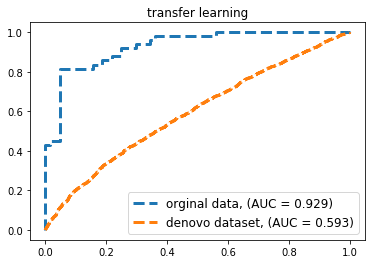

In [14]:
gb = fitting_gb(Xtrain, ytrain, Xtest, ytest, 0.15, 5, 100)
denovo_gb = fitting_gb(Xtrain, ytrain, X_test_denovo, y_test_denovo, 0.15, 5, 150)
drawROC(gb[0], gb[1], label = 'orginal data')
drawROC(denovo_gb [0], denovo_gb [1], label = 'denovo dataset', lastone = True, title = 'transfer learning')

In [19]:
#enrichment
features = [ 'MetaSVM_score', 'MetaLR_score', 'M-CAP_score', 'REVEL_score','ClinPred_score','CADD_phred_hg19',
            'DANN_score']
denovo['our_model'] = denovo_gb[1]
features.append('our_model')
features.append('UNEECON')

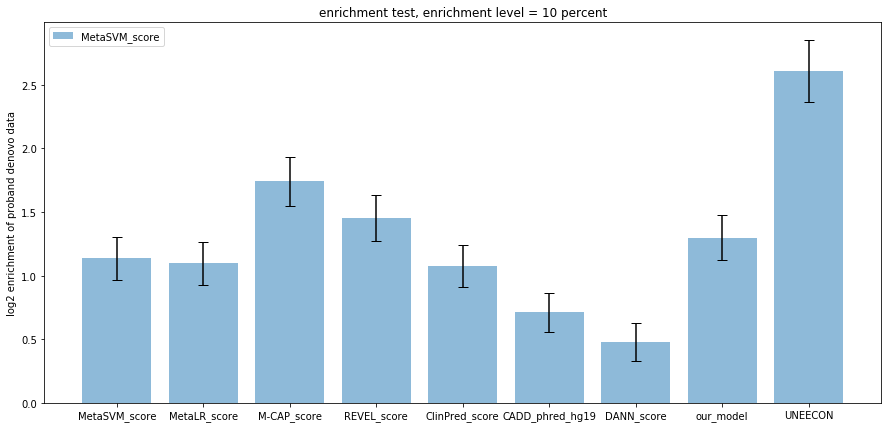

In [22]:
enrichment(denovo, 10, features) #2 as base

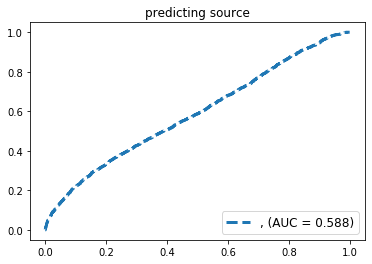

In [23]:
# DONT USE M-CAP AND REVEL as features

X_train, X_test, y_train, y_test, y_hat, regression = splitNfit(alldata, original_column, y_column, testsize = 0.3)
drawROC(y_test, y_hat, title = 'predicting source', lastone = True)

[[13314   712]
 [ 1556   250]]


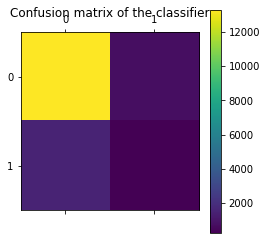

[[12732  1294]
 [ 1426   380]]


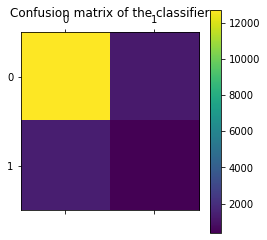

[[12103  1923]
 [ 1326   480]]


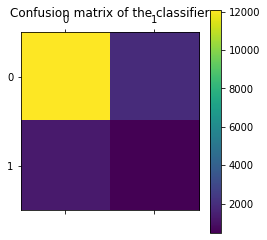

In [28]:
confusionmatrix(y_test, y_hat, 0.175 )
confusionmatrix(y_test, y_hat, 0.16 )  #chose 0.16 as cutoff
confusionmatrix(y_test, y_hat, 0.15 )

  


In [30]:
false_pos_loc = prediction_location(y_hat, y_test, 0.16)[4] #false_positive

new_train = X_test.iloc[np.r_[false_pos_loc[0]],:]
X = alldata.loc[:,x_column]
y = alldata.loc[:,['result']].values.flatten()
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = 0.3, random_state = 42)

clinvar_result = ytest[np.r_[false_pos_loc[0]],]
new_y = clinvar_result

# train gb
Xtrain, Xtest, ytrain, ytest = train_test_split(new_train, new_y, test_size = 0.1, random_state = 42)    
Xtrain, Xvalid, ytrain, yvalid =  train_test_split(Xtrain, ytrain, test_size = 0.11, random_state = 42)
tuning(Xvalid, yvalid, 'gradient boosting', tuned_parameters)

# Tuning hyper-parameters for recall



/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
With score : 0.796

Grid scores on development set:

0.790 (+/-0.122) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
0.782 (+/-0.078) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}
0.773 (+/-0.142) for {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
0.782 (+/-0.118) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
0.773 (+/-0.102) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150}
0.773 (+/-0.102) for {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
0.746 (+/-0.063) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100}
0.746 (+/-0.063) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 150}
0.746 (+/-0.063) for {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}
0.796 (+/-0.108) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.793 (+/-0.153) for {

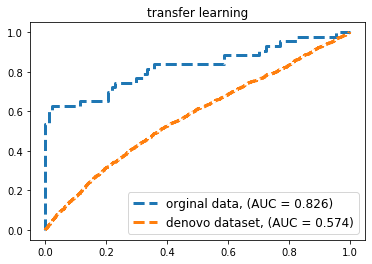

In [32]:
X_test_denovo = denovo.loc[:,original_column]
gb = fitting_gb(Xtrain, ytrain, Xtest, ytest, 0.1, 3, 100)
denovo_gb = fitting_gb(Xtrain, ytrain, X_test_denovo, y_test_denovo, 0.1, 3, 100)
drawROC(gb[0], gb[1], label = 'orginal data')
drawROC(denovo_gb [0], denovo_gb [1], label = 'denovo dataset', lastone = True, title = 'transfer learning')

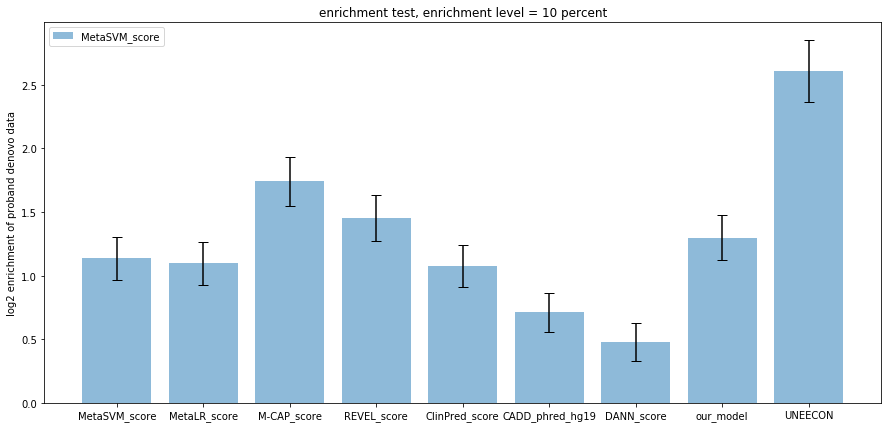

In [33]:
enrichment(denovo, 10, features) #2 as base